Import libraries

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

%matplotlib inline

Extract data and train and test dataset

In [15]:
cifar100 = tf.keras.datasets.cifar100
(X_train,Y_train) , (X_test,Y_test) = cifar100.load_data()

In [16]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Let's look into the dataset images

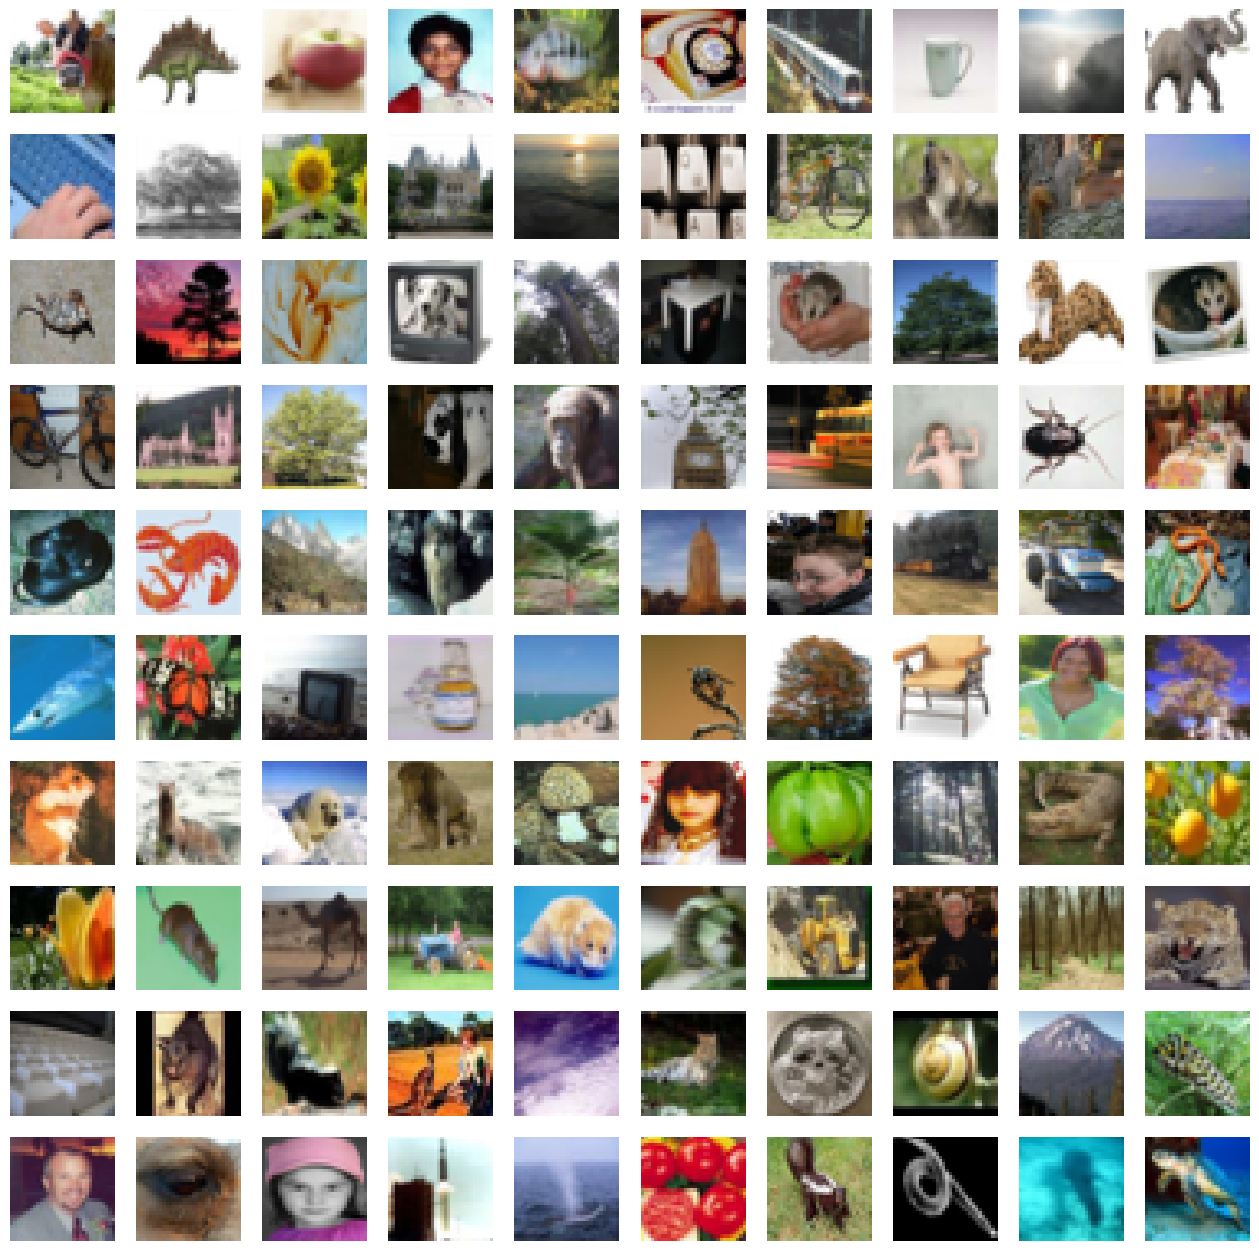

In [17]:
plt.figure(figsize = (16,16))
for i in range(100):
  plt.subplot(10,10,1+i)
  plt.axis('off')
  plt.imshow(X_train[i], cmap = 'gray')

Training , Validating and Splitting trained and tested data

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,test_size=0.2)

In [19]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 100)
y_val = to_categorical(y_val, num_classes = 100)

In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(40000, 32, 32, 3)
(40000, 100)
(10000, 32, 32, 3)
(10000, 100)
(10000, 32, 32, 3)
(10000, 1)


In [21]:
train_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    horizontal_flip = True
)
train_datagen.fit(x_train)

val_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg19.preprocess_input)
val_datagen.fit(x_val)

In [22]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.001)

We have used only 16 layers out of 19 layers in the CNN

In [23]:
vgg_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(32,32,3),
)

vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [24]:
model = tf.keras.Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 4096)              2101248   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_5 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_6 (Dense)             (None, 100)              

In [25]:
optimizer = tf.keras.optimizers.SGD(lr = 0.001, momentum = 0.9)
model.compile(optimizer= optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [26]:
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size = 128),
    validation_data = val_datagen.flow(x_val,y_val, batch_size = 128),
    epochs = 25,
    verbose = 1,
    callbacks = [learning_rate_reduction]
)

Epoch 1/25
313/313 [==============================] - 29s 86ms/step - loss: 4.9011 - accuracy: 0.0094 - val_loss: 4.6058 - val_accuracy: 0.0076 - lr: 0.0100
Epoch 2/25
313/313 [==============================] - 26s 84ms/step - loss: 4.6054 - accuracy: 0.0097 - val_loss: 4.6064 - val_accuracy: 0.0077 - lr: 0.0100
Epoch 3/25
313/313 [==============================] - 26s 84ms/step - loss: 4.6053 - accuracy: 0.0103 - val_loss: 4.6068 - val_accuracy: 0.0077 - lr: 0.0100
Epoch 4/25
313/313 [==============================] - 26s 85ms/step - loss: 4.6053 - accuracy: 0.0099 - val_loss: 4.6071 - val_accuracy: 0.0077 - lr: 0.0100
Epoch 5/25
313/313 [==============================] - 27s 85ms/step - loss: 4.6052 - accuracy: 0.0099 - val_loss: 4.6074 - val_accuracy: 0.0076 - lr: 0.0100
Epoch 6/25
313/313 [==============================] - ETA: 0s - loss: 4.6052 - accuracy: 0.0104
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
313/313 [==============================] - 2

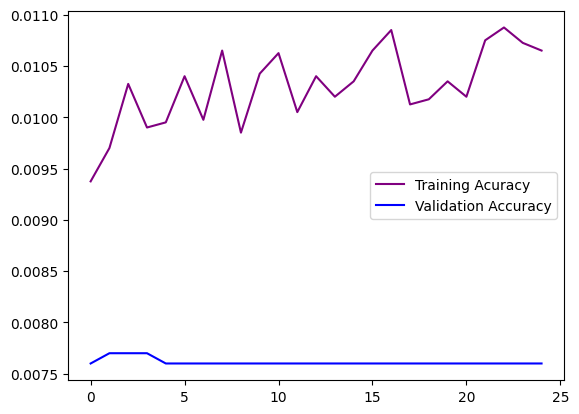

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure()
plt.plot(acc,color = 'purple',label = 'Training Acuracy')
plt.plot(val_acc,color = 'blue',label = 'Validation Accuracy')
plt.legend()

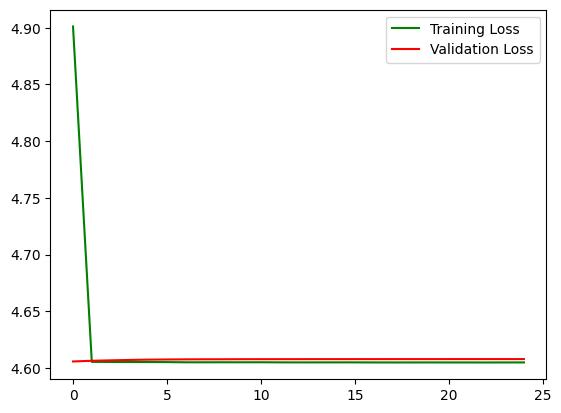

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss,color = 'green',label = 'Training Loss')
plt.plot(val_loss,color = 'red',label = 'Validation Loss')
plt.legend()